# **Libraries**

In [1]:
import math
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# **Loading Dataset**

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

# **Display Sample Data**

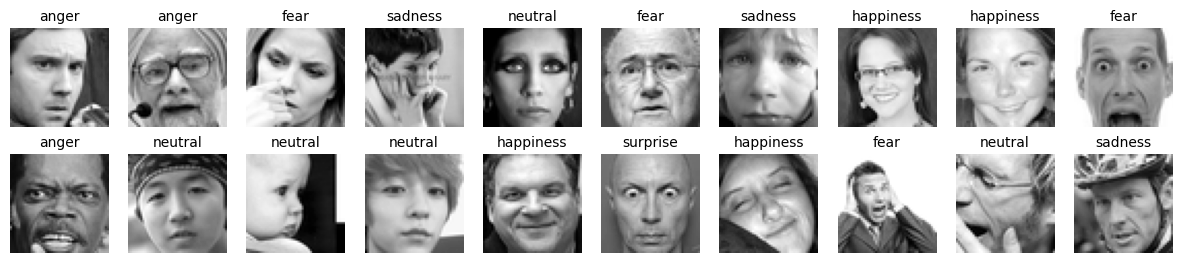

In [3]:
emotion_label={0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (15, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    img_pixels=np.reshape(np.array(df.iloc[i,1].split(' ')).astype('float32'),(48,48))
    ax.imshow(img_pixels, cmap='gray')
    ax.set_title(emotion_label[df.iloc[i,0]],fontsize=10)
    plt.axis('off')

# **Pre-Processing**

In [4]:
reshaped_img = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(reshaped_img, axis = 0)
img_array.shape
img_features = []
for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


# **Label Encoding**

In [5]:
le = LabelEncoder()
img_labels = to_categorical(df.emotion)
img_labels.shape

(35887, 7)

# **Create Training and Validation Set**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 41)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

# **Normalization**

In [7]:
X_train = X_train / 255.
X_valid = X_valid / 255.

# **Creating VGG19 Model**

In [8]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))
for layer in vgg.layers:
    layer.trainable = True

vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

# **Transfer Learning**
 Custom Feature Extraction Head with Global Average Pooling and Dense Layer

In [9]:
def Head_Layers(target_model, classes):
    model = target_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

# create our specific model
num_classes = y_train.shape[1]
hl = Head_Layers(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = hl)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# **Callbacks**
Callbacks have been specified to be called at certain points during the training process of the neural network. These callback functions are used to perform actions at specific events, such as the end of an epoch, before or after a batch, or when the model reaches a certain performance threshold.

In [10]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

# **Data Augmentation**
The goal is to expose the model to a wider range of variations in the input data, helping the model generalize better to unseen examples, since our available labeled data is limited.

In [11]:
data_generator = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
data_generator.fit(X_train)

# **Optimizer**
For this model we use SGD optimizer with Learning of 0.001.

In [12]:
optimizer = optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)


# **Compile**

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

# **Plot the model**

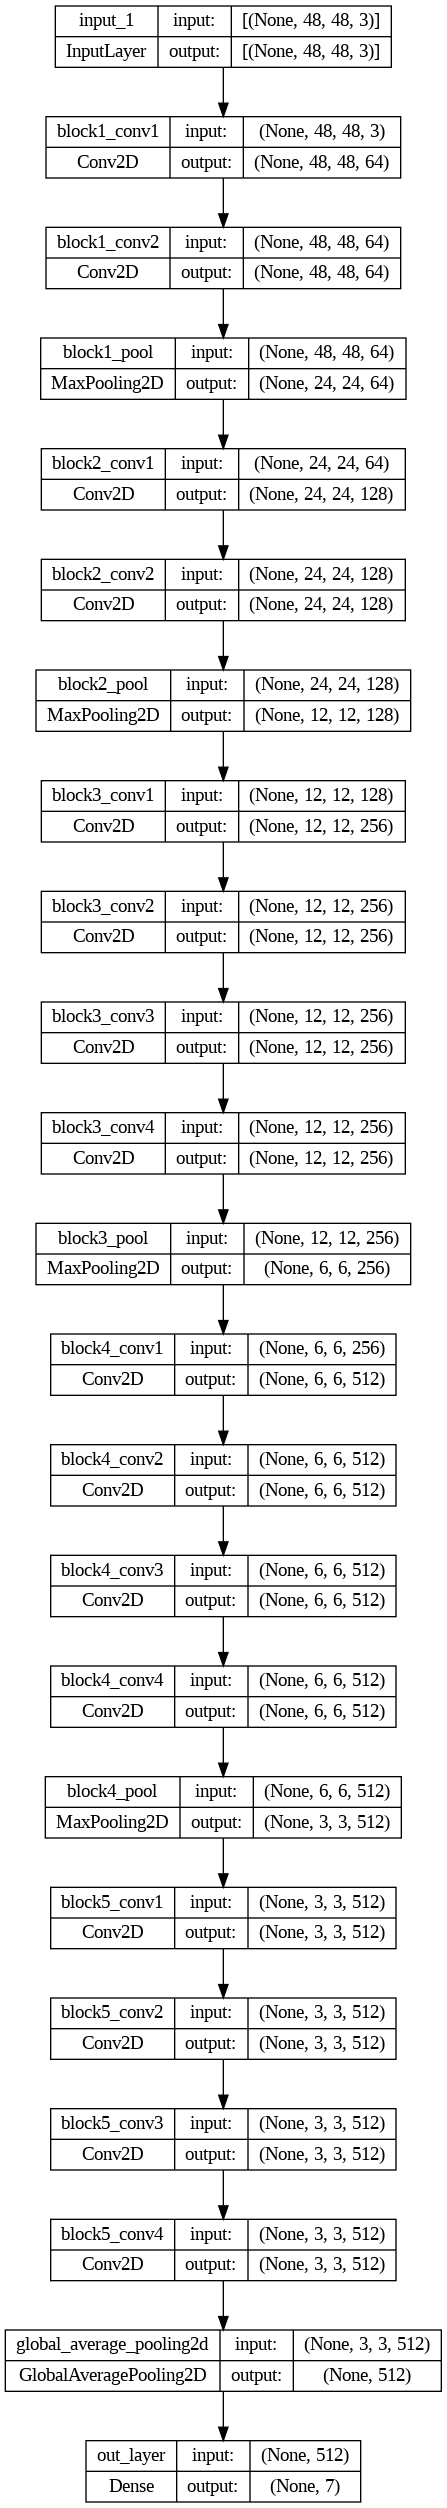

In [14]:
model_plot = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=model_plot, show_shapes=True)

# **Train the Model**

In [15]:
batch_size = 32
epochs = 50

history = model.fit(data_generator.flow(X_train,
                                        y_train,
                                        batch_size = batch_size),
                                        validation_data = (X_valid, y_valid),
                                        steps_per_epoch = len(X_train) / batch_size,
                                        epochs = epochs,
                                        callbacks = callbacks,
                                        use_multiprocessing = True)

Epoch 1/50
1009/1009 [==============================] - 77s 61ms/step - loss: 1.4198 - accuracy: 0.4528 - val_loss: 1.2745 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 2/50
1009/1009 [==============================] - 60s 59ms/step - loss: 1.2155 - accuracy: 0.5357 - val_loss: 1.1717 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 3/50
1009/1009 [==============================] - 60s 59ms/step - loss: 1.1408 - accuracy: 0.5676 - val_loss: 1.0767 - val_accuracy: 0.5874 - lr: 0.0010
Epoch 4/50
1009/1009 [==============================] - 59s 59ms/step - loss: 1.0923 - accuracy: 0.5867 - val_loss: 1.0406 - val_accuracy: 0.6099 - lr: 0.0010
Epoch 5/50
1009/1009 [==============================] - 60s 59ms/step - loss: 1.0571 - accuracy: 0.6020 - val_loss: 1.0211 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 6/50
1009/1009 [==============================] - 62s 61ms/step - loss: 1.0251 - accuracy: 0.6108 - val_loss: 1.0692 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 7/50
1009/1009 [========================

In [16]:
model_yaml = model.to_json()
with open("model_1.yaml", "w") as yaml_file:
     yaml_file.write(model_yaml)
model.save("mode_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Validation Accuracy and Loss Plot**

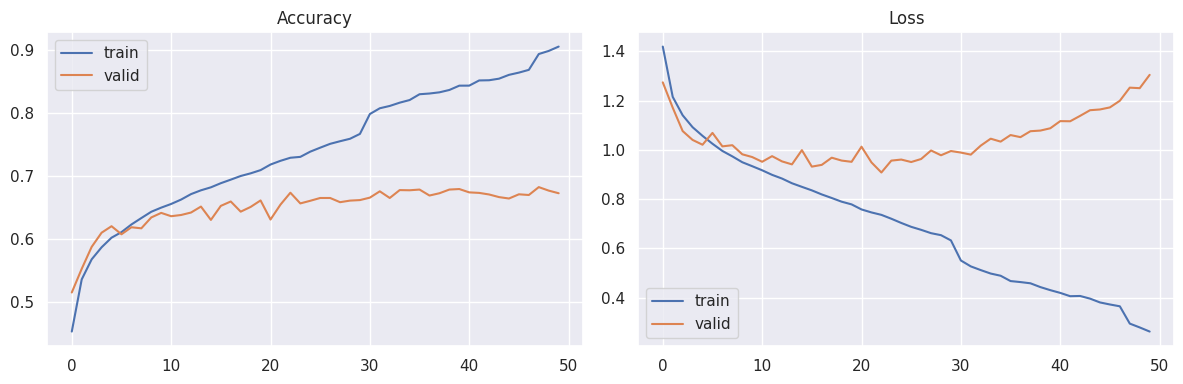

In [17]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

# **Confusion Matrix**

In [18]:
import sklearn as sk
ypred_valid = np.argmax(model.predict(X_valid), axis=1)
ymax_valid=np.argmax(y_valid, axis=1)

print(sk.metrics.accuracy_score(ymax_valid, ypred_valid))
print(sk.metrics.confusion_matrix(ymax_valid, ypred_valid))
print(sk.metrics.classification_report(ymax_valid, ypred_valid))

113/113 [==============================] - 2s 14ms/step
0.6726107550849819
[[293   3  43  21  73  16  46]
 [  7  43   1   0   3   0   1]
 [ 72   5 255   8  87  49  36]
 [ 29   1  17 764  22  23  43]
 [ 74   4  88  23 336   7  76]
 [  8   0  24  12   9 339   8]
 [ 44   0  35  42  95  20 384]]
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       495
           1       0.77      0.78      0.77        55
           2       0.55      0.50      0.52       512
           3       0.88      0.85      0.86       899
           4       0.54      0.55      0.55       608
           5       0.75      0.85      0.79       400
           6       0.65      0.62      0.63       620

    accuracy                           0.67      3589
   macro avg       0.67      0.68      0.67      3589
weighted avg       0.67      0.67      0.67      3589

